# eXplainable Machine Learning Lab 4
Tomasz Siłkowski 407106


In this homework I was tasked with using SHAP explainers.  
For my dataset I've selected [phoneme dataset](https://www.openml.org/search?type=data&sort=runs&id=1489&status=active) from OpenML-100. It contains accustical measurements of given sounds and a flag whether a given combination is a nasal or an oral sound.
Variables `V1` - `V5` are floating point numbers (with mean 0 and standard deviation 1), `Class` variable is a binary one. This makes this task a binary classification.

## Task A

In [85]:
shap_attributions[0].plot(shap_attributions[1:])

In this plot we can see, that for different observations contributions by the same variables can be different: in sample 1809 V2 has negative attribution, while in sample 402 it has positive attribution (5). We can also see, that importance of variables has changed between the samples (4).  

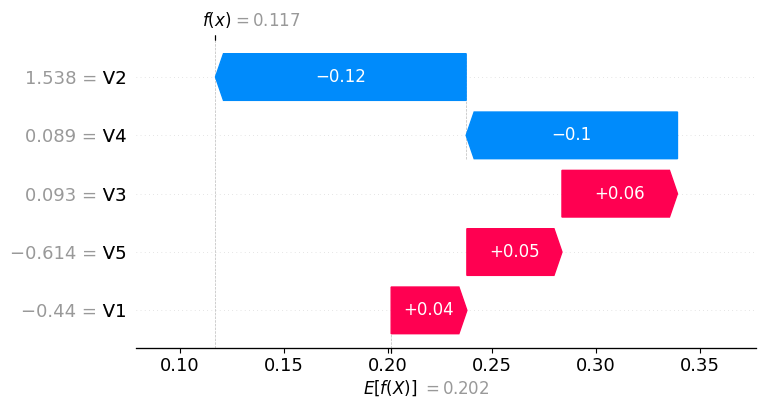

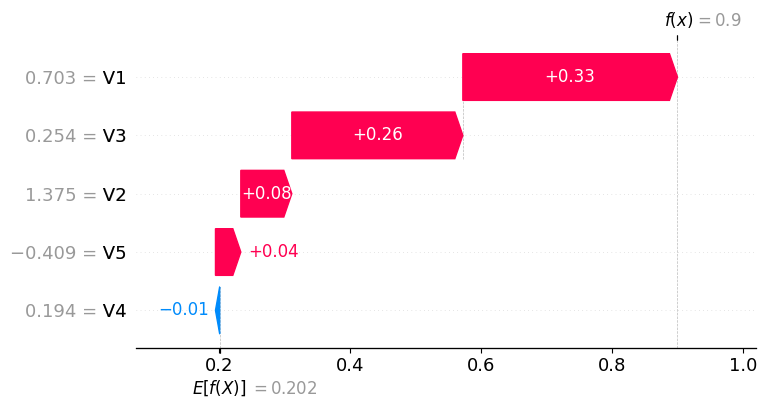

In [79]:
for i in selected_idxs:
    shap.plots.waterfall(shap_values[i])

Using `shap` instead of `dalex` has preserved main ideas: V2, V4 being main and negative contributors in sample 1809 and V1 and V2 being main and negative contributors in sample 402. However, there are small changes in specific values of contributions of variables, enough to slightly change the order of their importance(6).  

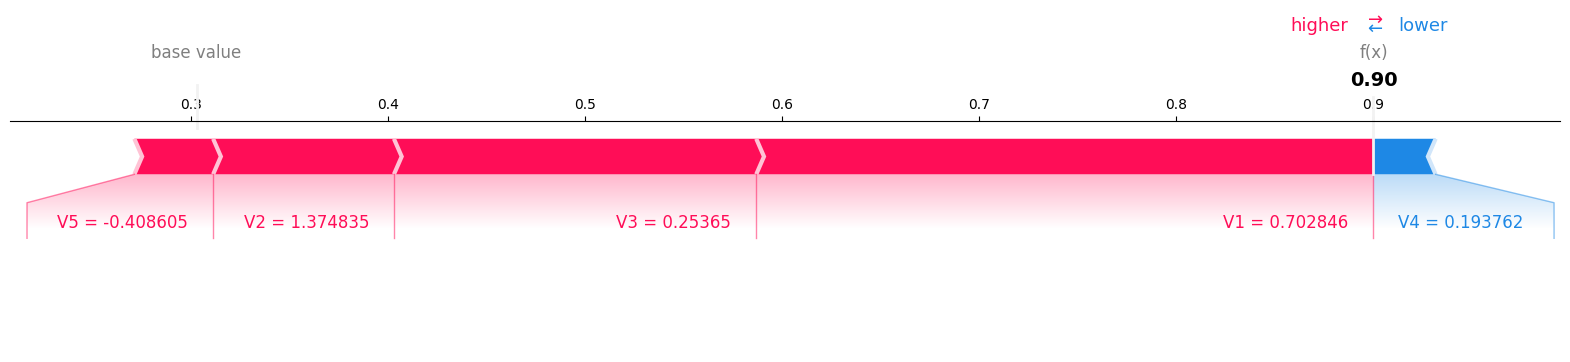

In [84]:
shap_attributions_xgboost[1].plot()

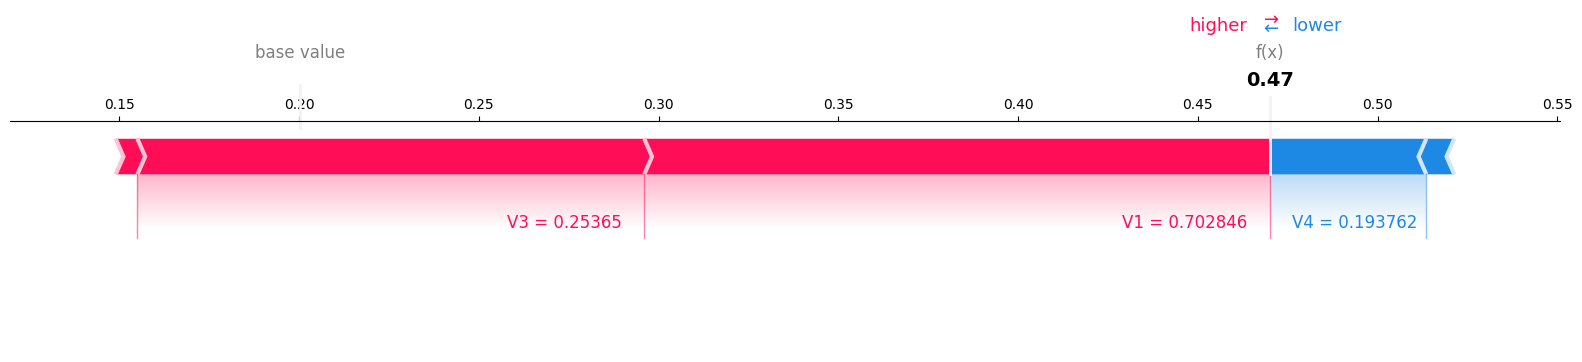

In [83]:
shap_attributions_rfc[1].plot()

After training an additional Random Forest Classifier model and using `dalex` SHAP explainer on it, we can see the the second sample (402) yields different explanations if run through different models.  

# Task B


$$
v(∅) = 0 \\
v(A) = 20 \\
v(B) = 20 \\
v(C) = 60 \\
v(A, B) = 60 \\
v(A, C) = 70 \\
v(B, C) = 70 \\
v(A, B, C) = 100 \\
$$
I'm going to use the following formula:
$$
\phi_A(v) = \sum_{S \subseteq \mathbb{N} \setminus \{A\}}\frac{|S|!(n - |S| - 1)!}{n!} (v(S \cup \{A\}) - v(S))
$$
First, let's calculate marginal contributions for player A:
$$
v(A) - v(∅) = 20 - 0 = 20 \\
v(A, B) - v(B) = 60 - 20 = 40 \\
v(A, C) - v(C) = 70 - 60 = 10 \\
v(A, B, C) - v(B, C) = 100 - 70 = 30 \\
$$
Let's plug those numbers in:
$$
\phi_A(v) = \frac{1!2!}{3!} \cdot 20 + \frac{1!1!}{3!} \cdot 40 + \frac{1!1!}{3!} \cdot 10 + \frac{2!1!}{3!} \cdot 30 = \frac{40}{6} + \frac{40}{6} + \frac{10}{6} + \frac{60}{6} = \frac{150}{6} = 25
$$

# Appendix
Code used for this analysis

In [14]:
import dalex as dx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split


raw_data = loadarff('php8Mz7BG.arff')
df_data = pd.DataFrame(raw_data[0])
df_data['Class'] = df_data['Class'].map({df_data.at[1, 'Class']: 0, df_data.at[10, 'Class']: 1})

In [3]:
np.random.seed(2137)
df_data_x = df_data.loc[:, df_data.columns != 'Class']
df_data_y = df_data.loc[:, df_data.columns == 'Class']
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_data_x, df_data_y, shuffle=True)

In [48]:
def calc_accuracy(y_true, y_pred):
    return sum(y_true == y_pred)/len(y_true)


def train_xgboost(df_train_x, df_test_x, df_train_y, df_test_y):
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(df_train_x, df_train_y)
    y_train_pred = model.predict(df_train_x)
    y_test_pred = model.predict(df_test_x)
    return model


def train_rfc(df_train_x, df_test_x, df_train_y, df_test_y):
    model = RandomForestRegressor()
    model.fit(df_train_x, df_train_y)
    y_train_pred = model.predict(df_train_x)
    y_test_pred = model.predict(df_test_x)
    return model

In [49]:
xgboost_model = train_xgboost(df_train_x, df_test_x, df_train_y, df_test_y)

In [28]:
selected_idxs = [21, 37]
df_selected_x = df_test_x.iloc[selected_idxs]
df_selected_y = df_test_y.iloc[selected_idxs]

In [23]:
explainer_xgb = dx.Explainer(xgboost_model, df_test_x, df_test_y, predict_function=lambda m, d: m.predict_proba(d)[:, 1], label="Xgboost")

Preparation of a new explainer is initiated

  -> data              : 1351 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 1351 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Xgboost
  -> predict function  : <function <lambda> at 0x7b24921f2a70> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.7e-05, mean = 0.303, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.994, mean = -0.00218, max = 0.992
  -> model_info        : package xgboost

A new explainer has been created!


In [24]:
explainer_xgb.model_performance()

,recall,precision,f1,accuracy,auc
Xgboost,0.830049,0.823961,0.826994,0.895633,0.953311


In [26]:
explainer_xgb.predict(df_selected_x)

array([0.11703733, 0.900057  ], dtype=float32)

In [67]:
shap_attributions = [explainer_xgb.predict_parts(x, type="shap", label=f'sample {i}') for i, x in df_selected_x.iterrows()]
shap_attributions[0].plot(shap_attributions[1:])

In [35]:
breakdown_attributions = [explainer_xgb.predict_parts(x, type="break_down", label=f'sample {i}') for i, x in df_selected_x.iterrows()]
breakdown_attributions[0].plot(breakdown_attributions[1:])

In [38]:
shap_explainer = shap.explainers.Tree(xgboost_model, data=df_test_x, model_output='probability')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[20:11:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



In [39]:
shap_values = shap_explainer(df_test_x)

In [40]:
shap_values

.values =
array([[-0.00153977, -0.06272925, -0.01697687, -0.08892532, -0.02930704],
       [ 0.0362182 ,  0.17515695, -0.01517326,  0.18351086, -0.0297724 ],
       [ 0.08971801,  0.10822334,  0.09433839,  0.0932813 , -0.00362942],
       ...,
       [ 0.24628222,  0.11718262,  0.06514222,  0.18202943,  0.13675223],
       [ 0.36404088,  0.01040383, -0.10337508,  0.40066369,  0.08835284],
       [-0.02075468, -0.04406308, -0.07568939, -0.05340284, -0.007002  ]])

.base_values =
array([0.20153492, 0.20153492, 0.20153492, ..., 0.20153492, 0.20153492,
       0.20153492])

.data =
array([[-0.517015,  0.950399, -0.16483 , -0.110573, -0.360951],
       [-0.686325, -0.391011,  0.509575,  2.315413, -0.136583],
       [-1.256178, -2.448144, -2.599841, -2.376355, -0.136583],
       ...,
       [-0.592795, -0.359002,  0.837238,  0.83807 ,  0.97279 ],
       [-0.372139, -1.066705, -0.439819,  1.285761,  2.245506],
       [ 0.358826,  1.168845, -1.149792, -0.285145, -0.414844]])

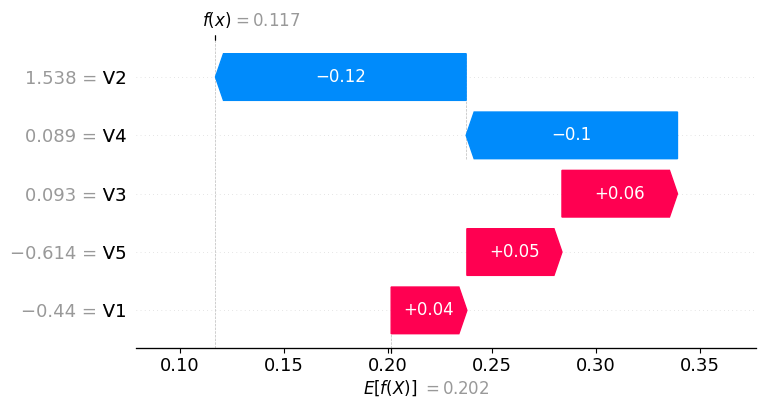

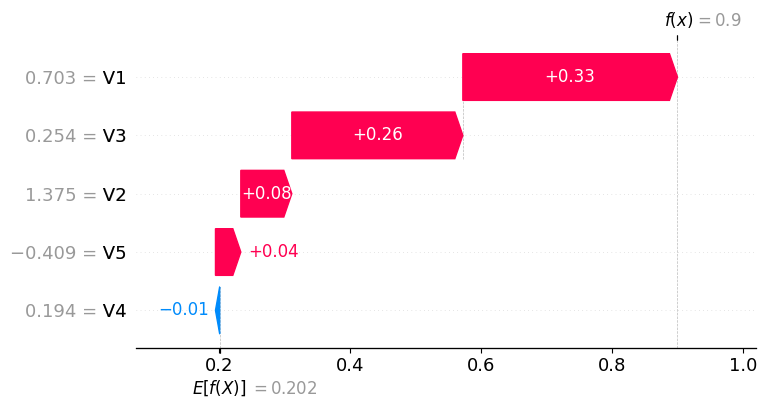

In [45]:
for i in selected_idxs:
    shap.plots.waterfall(shap_values[i])

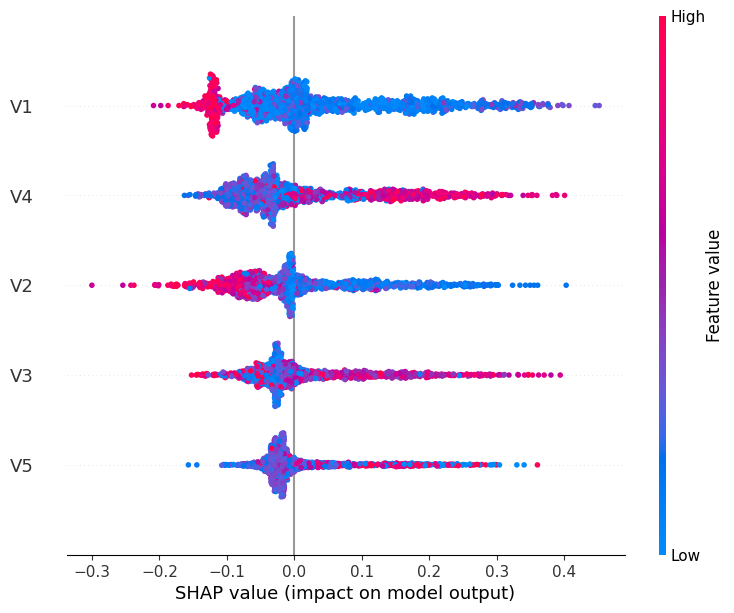

In [46]:
shap.plots.beeswarm(shap_values, max_display=10, plot_size=(9, 7))

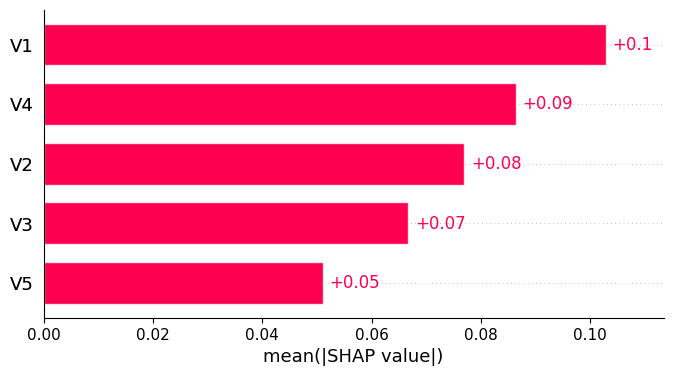

In [47]:
shap.plots.bar(shap_values, max_display=10)

In [52]:
rfc_model = train_rfc(df_train_x, df_test_x, df_train_y, df_test_y)

<ipython-input-48-c4b049bb55c7>:15: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [69]:
explainer_rfc = dx.Explainer(rfc_model, df_test_x, df_test_y, label="Random Forest Classifer")
explainer_xgb = dx.Explainer(xgboost_model, df_test_x, df_test_y, label="Xgboost")

Preparation of a new explainer is initiated

  -> data              : 1351 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 1351 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Random Forest Classifer
  -> predict function  : <function yhat_default at 0x7b24918b7e20> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.3, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.99, mean = 8.88e-05, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1351 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



In [70]:
explainer_rfc.model_performance()

,mse,rmse,r2,mae,mad
Random Forest Classifer,0.075344,0.274489,0.641571,0.159674,0.06


In [71]:
explainer_rfc.predict(df_selected_x)

array([0.12, 0.47])

In [77]:
shap_attributions_xgboost = [explainer_xgb.predict_parts(x, type="shap_wrapper") for i, x in df_selected_x.iterrows()]
shap_attributions_rfc = [explainer_rfc.predict_parts(x, type="shap_wrapper") for i, x in df_selected_x.iterrows()]

/usr/local/lib/python3.10/dist-packages/dalex/wrappers/_shap/checks.py:37: UserWarning:

`shap_explainer_type` parameter is None. Trying to determine the proper type: 
using KernelExplainer for <class 'xgboost.sklearn.XGBClassifier'>



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/dalex/wrappers/_shap/checks.py:37: UserWarning:

`shap_explainer_type` parameter is None. Trying to determine the proper type: 
using TreeExplainer for <class 'sklearn.ensemble._forest.RandomForestRegressor'>

